# Analysis

This analysis corresponds to the experiments produced by the adjacent scripts when run with the default configurations.

In [1]:
import os
import sys

if sys.path[0] != ".":
    os.chdir("..")
    sys.path.insert(0, ".")

In [9]:
from __future__ import annotations
from collections import defaultdict
import json
from pathlib import Path
from typing import ClassVar, Optional

from matplotlib import pyplot as plt

from mdalth.helpers import IOHelper

In [10]:
class Analyzer:

    _analysis: ClassVar[str] = "analysis/"
    _results: ClassVar[str] = "results.json"
    _learning_curve: ClassVar[str] = "learning_curve.png"

    def __init__(self, io_helper: IOHelper, keys: list[str] = ("eval_loss",)) -> None:
        self.io_helper = io_helper
        self.keys = keys
        self.test_metrics = []
        self.fig, self.ax = plt.subplots()
        self.n_iterations = None
        plt.close(self.fig)

    def __call__(self) -> Analyzer:
        self.analysis_path.mkdir(parents=True, exist_ok=True)

        self.n_iterations = sum(1 for _ in self.io_helper.iterations_path.iterdir())

        for i in range(self.n_iterations):
            with open(self.io_helper.test_metrics_path(i), "r") as fp:
                d = json.load(fp)
            if self.keys:
                d = {k: v for k, v in d.items() if k in self.keys}
            self.test_metrics.append(d)
        with open(self.results_file, "w") as fp:
            json.dump(self.test_metrics, fp, indent=4)

        x = list(range(self.n_iterations))
        for k in self.test_metrics[0].keys():
            self.ax.plot(x, [d[k] for d in self.test_metrics], label=k)
        self.ax.set_xlabel("Iteration")
        self.ax.set_ylabel("Metric")
        self.ax.grid()
        self.ax.legend()
        self.fig.savefig(self.learning_curve_file, dpi=400)
        return self

    @property
    def analysis_path(self) -> Path:
        return self.io_helper.meta_path / self._analysis

    @property
    def results_file(self) -> Path:
        return self.analysis_path / self._results

    @property
    def learning_curve_file(self) -> Path:
        return self.analysis_path / self._learning_curve

In [11]:
KEYS = ("eval_accuracy",)
QUERIERS = ("random", "uncertainty",  "margin", "entropy")
STOPPERS = ("null", "stabilizing_predictions", "changing_confidence")
CONFIG = Path(f"{64}/{64}/{0.1}")
analyzers = defaultdict(dict)
for querier in QUERIERS:
    for stopper in STOPPERS:
        root = Path(f"./examples/output/nlp/{querier}/{stopper}") / CONFIG
        if not root.exists():
            continue
        io_helper = IOHelper(root)
        if any(["test_metrics.json" not in [f.name for f in p.iterdir()] for p in io_helper.iterations_path.iterdir()]):
            continue
        a = Analyzer(io_helper, KEYS)()
        analyzers[querier][stopper] = a

In [12]:
class QuerierAnalyzer:

    markers: ClassVar[list[str]] = [".", "x", "+", "o"]
    colors: ClassVar[list[str]] = ["red", "blue", "green", "purple"]

    def __init__(self, analyzers: list[Analyzer], labels: list[str]) -> None:
        self.analyzers = analyzers
        self.labels = labels
        self.fig, self.ax = plt.subplots()

    def __call__(self, outfile: Optional[Path] = None) -> QuerierAnalyzer:
        max_iter = 0
        for i, (analyzer, label) in enumerate(zip(self.analyzers, self.labels)):
            x = list(range(analyzer.n_iterations))
            for _ in analyzer.test_metrics[0].keys():
                y = [d[KEYS[0]] for d in analyzer.test_metrics]
                self.ax.plot(x, y, label=label, marker=self.markers[i], color=self.colors[i])
            max_iter = max(len(x), max_iter)
        self.ax.set_xlabel("Iteration")
        self.ax.set_ylabel(KEYS[0])
        self.ax.set_ylim(0, 1)
        self.ax.set_xlim(0, max_iter)
        self.ax.grid()
        self.ax.legend()
        self.ax.legend()
        self.fig.show()
        if outfile is not None:
            self.fig.savefig(outfile, dpi=400)

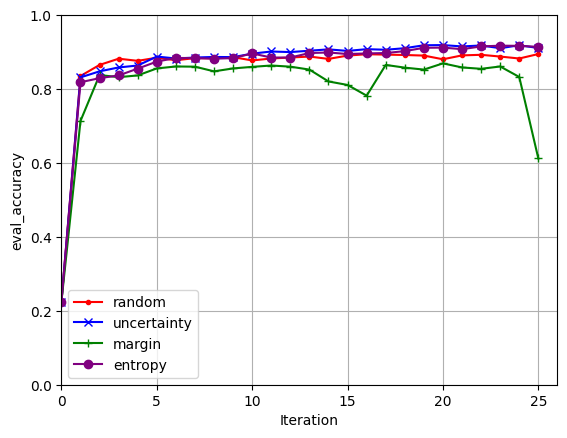

In [13]:
qa = QuerierAnalyzer([analyzers[q]["null"] for q in analyzers], QUERIERS)
qa = qa("./examples/output/nlp/queriers.png")